In [48]:
import warnings

In [49]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re
import pprint
from custom_library.custom_lib import *

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans


from collections import defaultdict
from collections import Counter, ChainMap

from wordcloud import WordCloud

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

import pyLDAvis.sklearn

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [50]:
pd.options.mode.chained_assignment = None

df_full = import_dataset(encoding='utf-8')
df_full.shape


(9359, 5)

# Dataset preprocessing:

Cases of Unknown Homeland (Ukendt hjemland) are kept.

Below we see the shape and head of the dataset.

In [51]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

(192, 1)

In [52]:

df.head()

text
224           Nævnet stadfæstede i november 2021 Udl...
451           Nævnet stadfæstede i juni 2021 Udlændi...
487           Nævnet stadfæstede i juni 2021 Udlændi...
930           Nævnet stadfæstede i december 2020 Udl...
1320          Nævnet hjemviste i juni 2020 Udlænding...

Check for potential duplicates and drop them:

In [53]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

text
1362          Nævnet stadfæstede i maj 2020 Udlændin...
1381          Nævnet stadfæstede i maj 2020 Udlændin...
4035          Nævnet stadfæstede i januar 2018 Udlæn...
4036          Nævnet stadfæstede i januar 2018 Udlæn...
4090          Nævnet stadfæstede i januar 2018 Udlæn...
4093          Nævnet stadfæstede i januar 2018 Udlæn...

New shape for dataset after droping duplicate entries.

In [54]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(189, 1)

# Use a pipeline to pre-process the texts:

The pipeline consists of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found [here](https://github.com/jethronap/AsylumData_KU/blob/main/misc/stopwords_dk.txt).
- Single letter words are dropped, too.
- Tokenization
- Lemmatization. The process during which all words are turned into its roots. 

Steps can be added or removed from the pipeline.

In [55]:
pipeline = [str.lower, drop_numbers, remove_punctuation, remove_stopwords, drop_single_letter_words,
            tokenize, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [56]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [57]:
df.head()

text  \
224           Nævnet stadfæstede i november 2021 Udl...   
451           Nævnet stadfæstede i juni 2021 Udlændi...   
487           Nævnet stadfæstede i juni 2021 Udlændi...   
930           Nævnet stadfæstede i december 2020 Udl...   
1320          Nævnet hjemviste i juni 2020 Udlænding...   

                                                 tokens  num_tokens  
224   [stadfæste, udlændingestyrels, afgørelse, vedr...         319  
451   [stadfæste, udlændingestyrels, afgørelse, vedr...         215  
487   [stadfæste, udlændingestyrels, afgørelse, vedr...         309  
930   [stadfæste, udlændingestyrels, afgørelse, vedr...         180  
1320  [hjemvise, udlændingestyrels, afgørelse, vedrø...         315

# Analysis:

In [58]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

## Topic Modelling:

### Latent Dirichlet Allocation (LDA):


Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

For a given corpus, a topic model estimates a topic distribution for each of its documents (i.e., a a distribution of weights over a set of topics), where a topic is itself a distribution of weights over the vocabulary of the corpus. The most weighted words of each topic are syntactically and/or semantically related, given that collection of documents. This means that two distinct topics share the exact same vocabulary, but have different weight distributions.

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

REFs here [1](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) and [2](https://arxiv.org/pdf/1405.0099.pdf).

Assumptions:

- Each document is just a collection of words or a “bag of words”. Thus, the order of the words and the grammatical role of the words (subject, object, verbs, …) are not considered in the model.
- Words like am/is/are/of/a/the/but/… don’t carry any information about the “topics” and therefore can be eliminated from the documents as a preprocessing step. In fact, we can eliminate words that occur in at least %80 ~ %90 of the documents, without losing any information. For example, if our corpus contains only medical documents, words like human, body, health, etc might be present in most of the documents and hence can be removed as they don’t add any specific information which would make the document stand out.
- We know beforehand how many topics we want. ‘k’ is pre-decided.
- All topic assignments except for the current word in question are correct, and then updating the assignment of the current word using our model of how documents are generated

REFS [1](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)

- A document is a probability distribution of topics, and every topic is a probability distribution of words.
- What LDA does is that when you fit it with all those document, it is trying its best to find the best topic mix and the best word mix.

Assumptions of LDA for Topic Modelling:
- Documents with similar topics use similar groups of words
- Latent topics can then be found by searching for groups of words that frequently occur together in documents across the corpus
- Documents are probability distributions over latent topics which signifies certain document will contain more words of a specific topic.

Limitations:
- Fixed K (the number of topics is fixed and must be known ahead of time) There is limit to amount of topics we can generate
- Uncorrelated topics (Dirichlet topic distribution cannot capture correlations)
- Non-hierarchical (in data-limited regimes hierarchical models allow sharing of data)
- Static (no evolution of topics over time)
- Bag of words (assumes words are exchangeable, sentence structure is not modelled)
- Unsupervised (sometimes weak supervision is desirable, e.g. in sentiment analysis)



In [59]:
count_text_vectorizer = CountVectorizer(min_df=2, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['tokens_joined'])

tfidf_text_vectorizer = TfidfVectorizer(min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
# tfidf_text_vectors.shape


**Coherence Score**:

Compute the coherence score is essentially a measure of how similar the words assigned to each topic are in terms of semantic value. The higher the score, the better.

Compute the coherence score for LDA models with 2 to 10 topics and see which number of topics leads to the highest coherence score.

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [60]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_num_LDA = float('NaN')
best_score_LDA = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create LDA model with i topics
    LDA_text_model = LatentDirichletAllocation(n_components=i, random_state=42)
    W_LDA_text_matrix = LDA_text_model.fit_transform(count_text_vectors)
    H_LDA_text_matrix = LDA_text_model.components_

    # Obtain the coherence score
    coherence_model_LDA = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_LDA_text_matrix, 
                        dtm=W_LDA_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_LDA = np.around(coherence_model_LDA, 2)
    for score in coherence_score_LDA:
        if score > best_score_LDA:
            best_num_LDA = i
            best_score_LDA = score

print(f'The coherence score for LDA ({best_score_LDA}) is highest with {best_num_LDA} topics.')

The coherence score for LDA (0.78) is highest with 10 topics.


Build the model with the best number of topics and see them:

In [61]:
LDA_model = LatentDirichletAllocation(n_components=best_num_LDA, random_state=42)
W_LDA_model_matrix = LDA_model.fit_transform(count_text_vectors)
H_LDA_model_matrix = LDA_model.components_

In [62]:
display_topics(LDA_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 bidoon (1.46)
 navn (1.34)
 ansøgere (1.09)
 år (0.90)
 bo (0.88)

Topic 01
 kvindelig (2.39)
 demonstration (1.24)
 dag (1.11)
 asylsamtale (1.04)
 bemærke (1.04)

Topic 02
 kvindelig (1.94)
 demonstration (1.70)
 videre (1.40)
 oplysnings (1.34)
 angiveligt (1.30)

Topic 03
 demonstration (1.95)
 bidoon (1.60)
 oplysning (1.29)
 deltage (1.15)
 barn (1.14)

Topic 04
 klager (1.83)
 libanon (1.22)
 ihjel (1.09)
 oplysning (1.08)
 ansøgere (1.08)

Topic 05
 eritrea (3.31)
 sudan (1.55)
 bopæl (1.23)
 flertal (1.15)
 mor (1.10)

Topic 06
 dag (2.49)
 kvindelig (1.98)
 gang (1.53)
 bopæl (1.35)
 tage (1.13)

Topic 07
 klager (9.49)
 opholdstilladelse (2.55)
 udlændingestyrelse (1.37)
 danmark (1.28)
 klagere (1.20)

Topic 08
 ægtefælle (2.83)
 demonstration (2.35)
 deltage (1.87)
 bror (1.44)
 bopæl (1.27)

Topic 09
 demonstration (2.49)
 bidoon (1.94)
 deltage (1.64)
 divergere (1.50)
 dag (1.40)


Visualise the topics produced by LDA:

In [79]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

LDA_display = pyLDAvis.sklearn.prepare(LDA_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(LDA_display)

Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.

### Non-Negative Matrix Factorization:

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

Non-Negative Matrix Factorization is a statistical method that helps us to reduce the dimension of the input corpora or corpora. Internally, it uses the factor analysis method to give comparatively less weightage to the words that are having less coherence

REFs here [1](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), [2](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45)

In [64]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_NMF = float('NaN')
best_score_NMF = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create NMF model with i topics
    NMF_text_model = NMF(n_components=i, random_state=42, max_iter=2000)
    W_NMF_text_matrix = NMF_text_model.fit_transform(count_text_vectors)
    H_NMF_text_matrix = NMF_text_model.components_

    # Obtain the coherence score
    coherence_model_NMF = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_NMF_text_matrix, 
                        dtm=W_NMF_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_NMF = np.around(coherence_model_NMF, 2)
    for score in coherence_score_NMF:
        if score > best_score_NMF:
            best_num_NMF = i
            best_score_NMF = score

print(f'The coherence score for NMF ({best_score_NMF}) is highest with {best_num_NMF} topics.')

The coherence score for NMF (0.78) is highest with 10 topics.


Build the model with the best number of topics and see them:

In [65]:
NMF_model = NMF(n_components=best_num_NMF, random_state=42, max_iter=2000)
W_NMF_model_matrix = NMF_model.fit_transform(count_text_vectors)
H_NMF_model_matrix = NMF_model.components_

The numbers inside the parentheses are the percentages with which the words contribute to the topics. Due to the large number of words, the individual contributions are quite small. The percentages of the words within a topic are a good indication for the quality of the topic model. If the percentage within a topic is rapidly decreasing, the topic is well-defined, whereas slowly decreasing word probabilities indicate a less-pronounced topic. It’s much more difficult to intuitively find out how well the topics are separated; 

**CONS**- Works best with shorter texts such as tweets or titles.

In [66]:
display_topics(NMF_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 demonstration (7.41)
 deltage (4.72)
 bidoon (2.06)
 dag (1.71)
 tilbageholde (1.62)

Topic 01
 klager (12.38)
 opholdstilladelse (3.22)
 klagere (1.65)
 danmark (1.41)
 nr (1.32)

Topic 02
 dag (2.95)
 bopæl (2.95)
 gang (2.62)
 tage (2.16)
 ægtefæll (1.85)

Topic 03
 ægtefælle (2.91)
 bidoon (2.50)
 ansøgere (2.36)
 navn (1.64)
 nærmere (1.55)

Topic 04
 kvindelig (2.58)
 demonstration (1.94)
 videre (1.88)
 oplysnings (1.71)
 bopæl (1.60)

Topic 05
 eritrea (5.83)
 sudan (2.83)
 år (2.37)
 eritreisk (1.54)
 etiopien (1.36)

Topic 06
 barn (2.39)
 oplysning (1.67)
 bidooner (1.53)
 sag (1.33)
 demonstration (1.28)

Topic 07
 kvindelig (5.04)
 dag (1.74)
 asylsamtale (1.34)
 ansøg (1.33)
 bidooner (1.25)

Topic 08
 bror (3.32)
 divergere (2.29)
 opholdstilladelse (1.06)
 ansøgere (1.05)
 sandsynliggjore (0.98)

Topic 09
 klager (8.18)
 pas (3.09)
 syrisk (3.02)
 jordan (1.97)
 syrien (1.92)


Visualise the topics produced by NMF:

In [67]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


NMF_display = pyLDAvis.sklearn.prepare(NMF_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(NMF_display)

### Latent Semantic Analysis/Indexing:

Similar analysis to NMF but using a different algorithm: Singular Value Decomposition (SVD).

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

With the rank reduction of the original matrix, what we have is an approximation of the document-term matrix, with a new representation of each document in our corpus. The idea behind LSA is that the original corpus consists of a multitude of terms that in essence have the same meaning. The original matrix can in this sense be viewed as an obscured version of the underlying latent structure we discover when the redundant dimensions are forced together.

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.



REFs here [1](https://simonpaarlberg.com)

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small, the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k. A less extensive way is just to try out a couple of different k-values and see what generates the best results."

LSA tries to leverage the context around the words to capture the hidden or latent concepts, which are called topics. Conceive SVD as rearranging documents and words in a way to uncover a block structure in the document-term matrix. 

The idea of SVD is finding the most valuable information and using lower dimension t to represent the same thing. 

**Disadvantages of LSA**

1. Since it is a linear model, it might not do well on datasets with non-linear dependencies.
2. LSA assumes a Gaussian distribution of the terms in the documents, which may not be true for all problems.
3. LSA involves SVD, which is computationally intensive and hard to update as new data comes up.
4. Lack of interpretable embeddings (we don’t know what the topics are, and the components may be arbitrarily positive/negative)
5. Need for a really large set of documents and vocabulary to get accurate results
6. It provides less efficient representation

In [68]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_SVD = float('NaN')
best_score_SVD = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create SVD model with i topics
    SVD_text_model = TruncatedSVD(n_components=i, random_state=42)
    W_SVD_text_matrix = SVD_text_model.fit_transform(count_text_vectors)
    H_SVD_text_matrix = SVD_text_model.components_

    # Obtain the coherence score
    coherence_model_SVD = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_SVD_text_matrix, 
                        dtm=W_SVD_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_SVD = np.around(coherence_model_SVD, 2)
    for score in coherence_score_SVD:
        if score > best_score_SVD:
            best_num_SVD = i
            best_score_SVD = score

print(f'The coherence score for SVD ({best_score_SVD}) is highest with {best_num_SVD} topics.')

The coherence score for SVD (0.76) is highest with 4 topics.


Build the model with the best number of topics and see them:

In [69]:
SVD_model = TruncatedSVD(n_components=best_num_SVD, random_state=42)
W_SVD_model_matrix = SVD_model.fit_transform(count_text_vectors)
H_SVD_model_matrix = SVD_model.components_

In [70]:
display_topics(SVD_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 demonstration (1.81)
 kvindelig (1.11)
 bidoon (1.08)
 deltage (1.07)
 bopæl (1.04)

Topic 01
 klager (58.50)
 opholdstilladelse (11.42)
 klagere (6.93)
 syrisk (6.28)
 pas (6.15)

Topic 02
 demonstration (-11.93)
 deltage (-9.14)
 oplysning (-5.78)
 bidoon (-5.65)
 barn (-4.90)

Topic 03
 ansøgere (7.29)
 ægtefælle (2.91)
 følge (2.62)
 mor (2.36)
 barn (2.34)


In [71]:
# SVD_display = pyLDAvis.sklearn.prepare(SVD_model, count_text_vectors, count_text_vectorizer, mds='tsne', sort_topics=False)

# pyLDAvis.display(SVD_display)

### Kmeans clustering:

Try to extract topics from the dataset using clustering techniques.

In [72]:
k_means_text = KMeans(n_clusters=10, random_state=42) 
k_means_text.fit(tfidf_text_vectors)

np.unique(k_means_text.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 2, 15,  9, 46, 11, 12,  9, 41,  2, 42]))

<AxesSubplot:xlabel='cluster'>

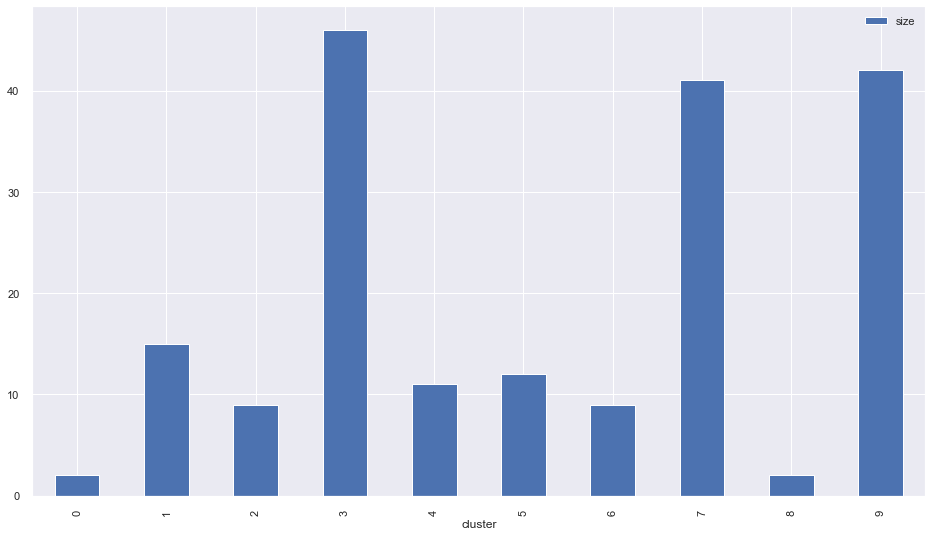

In [73]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_text.labels_==i)}) 
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))

## Wordclouds:

**WordClouds from the LDA model**:

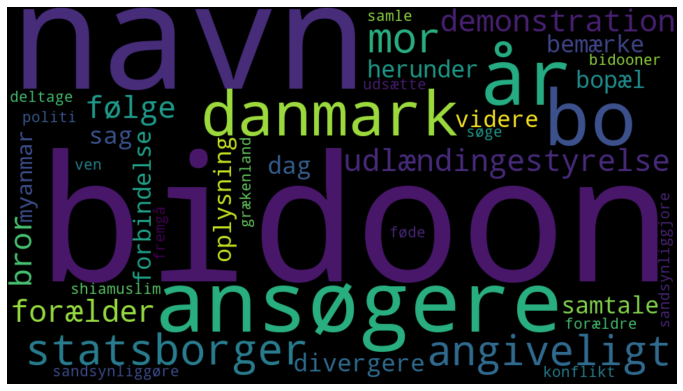

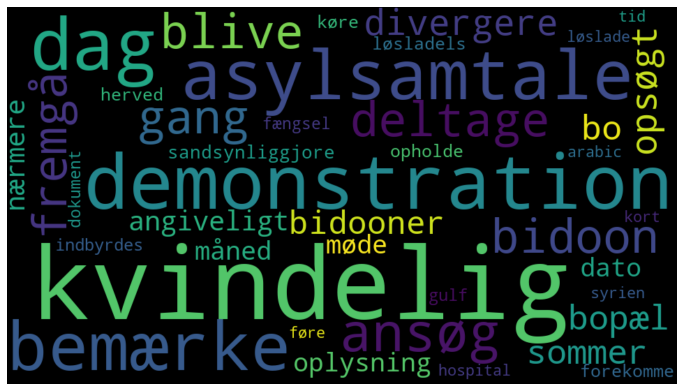

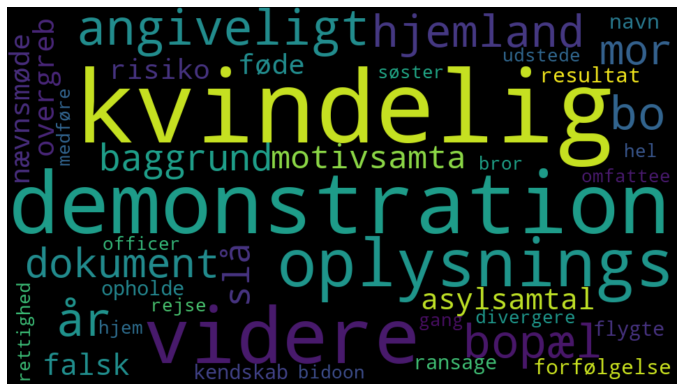

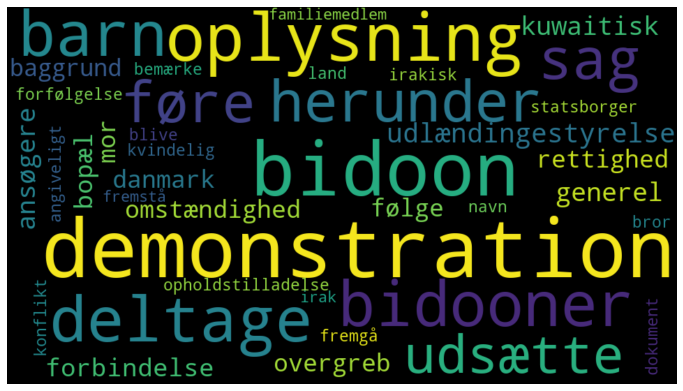

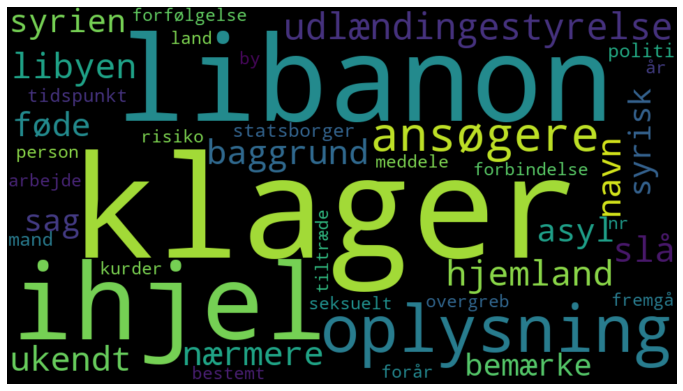

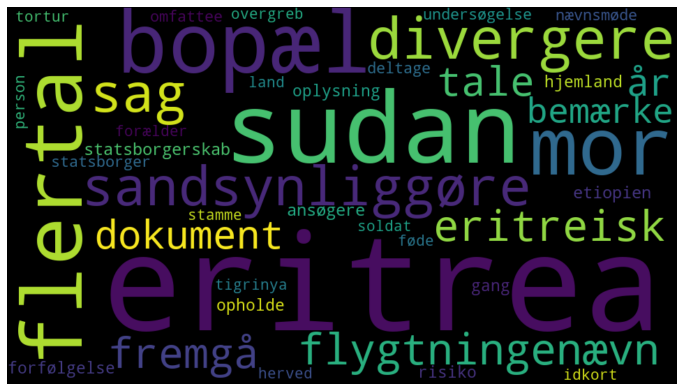

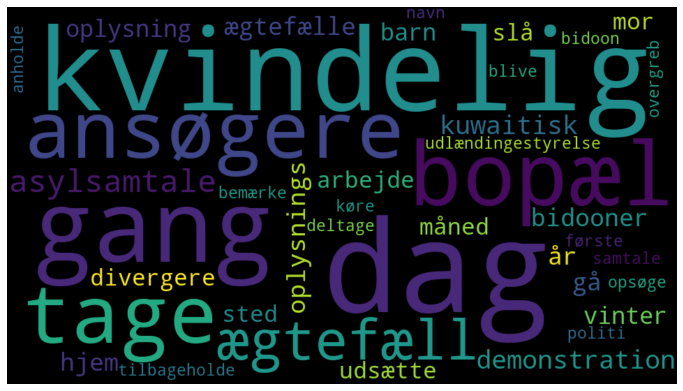

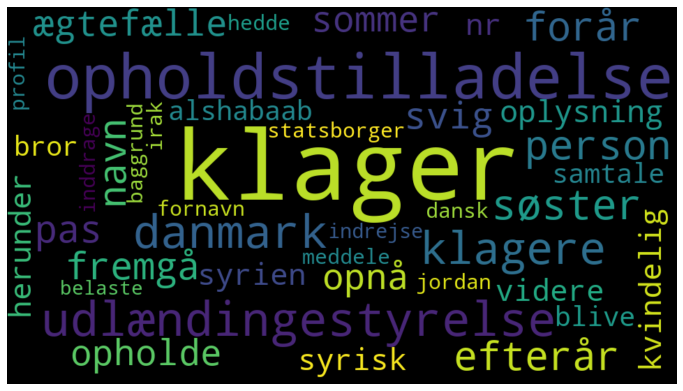

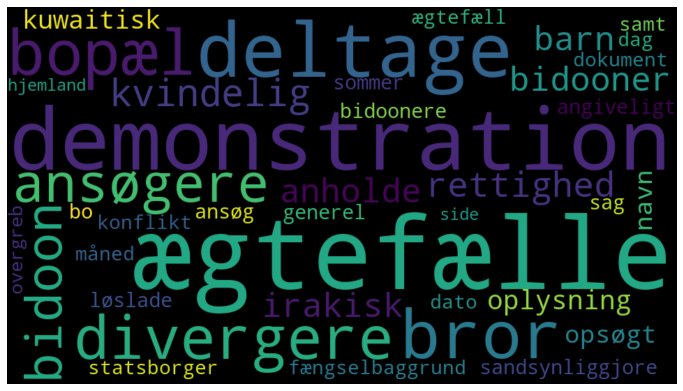

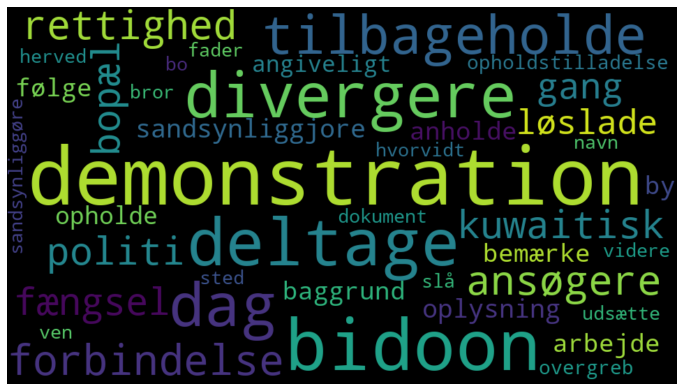

In [74]:
wordcloud_topics(LDA_model, count_text_vectorizer.get_feature_names_out())

**WordClouds from the NMF model**:

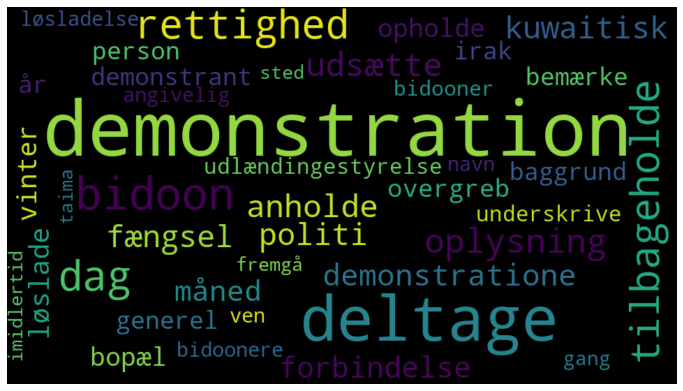

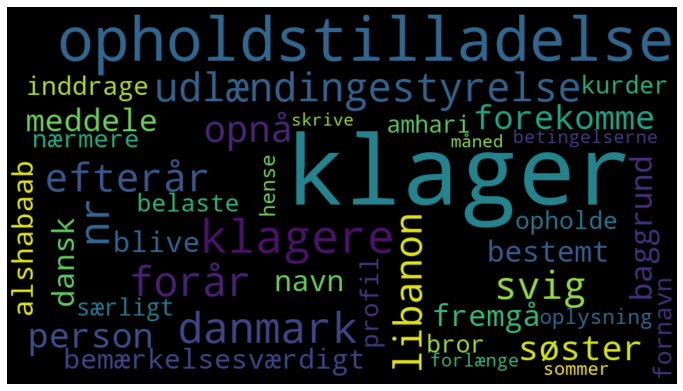

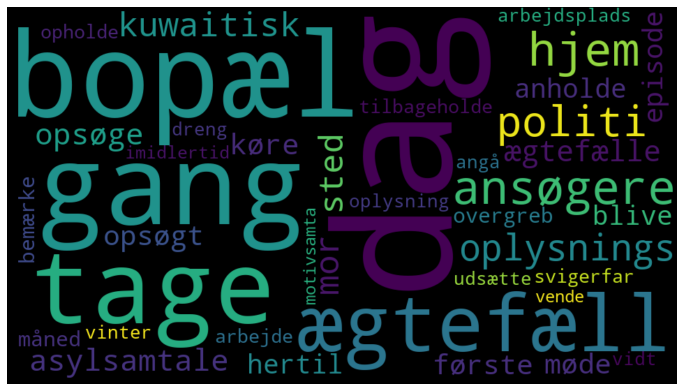

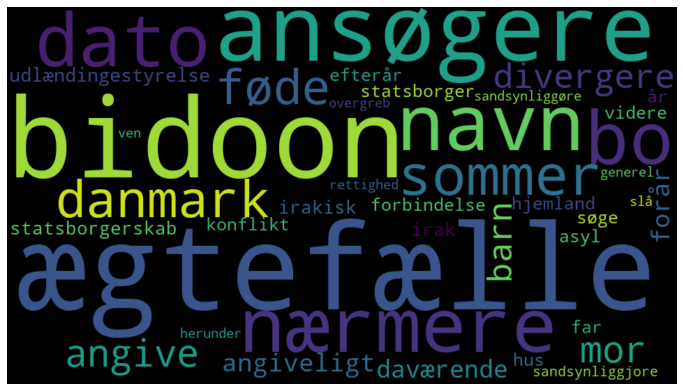

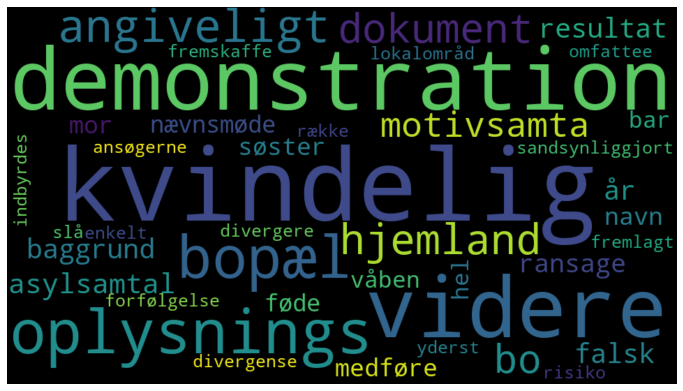

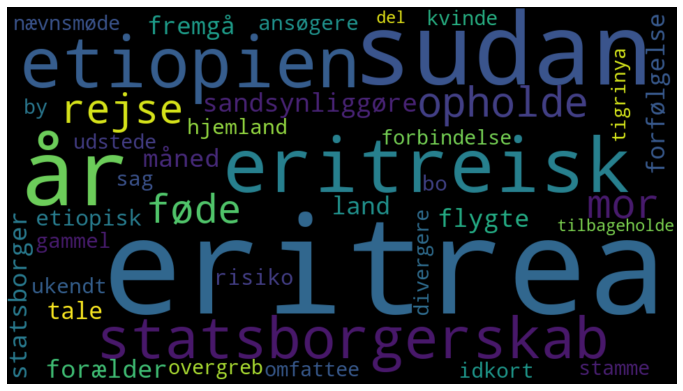

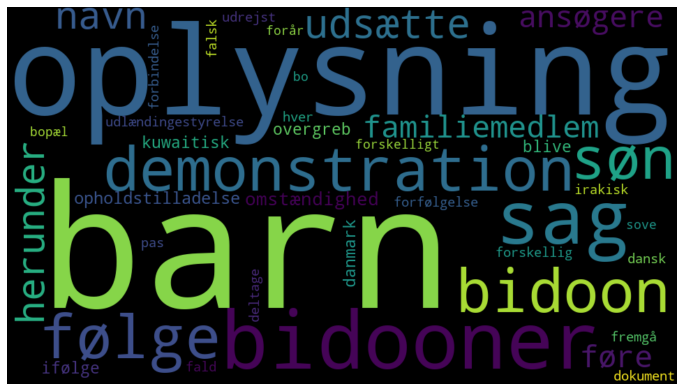

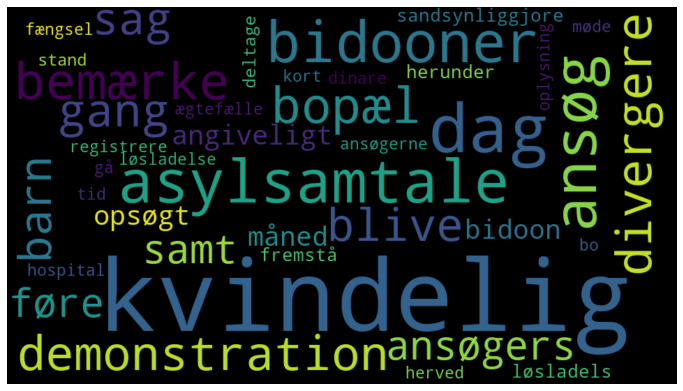

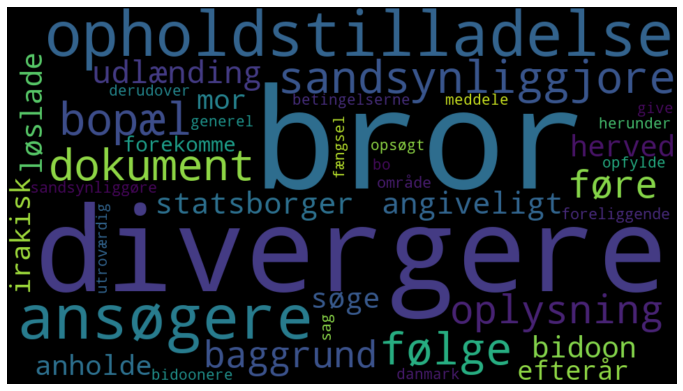

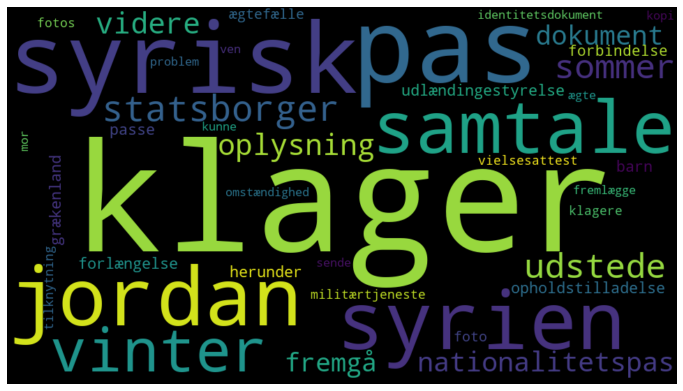

In [75]:
wordcloud_topics(NMF_model, count_text_vectorizer.get_feature_names_out())

**WordsClouds from the SVD model**:

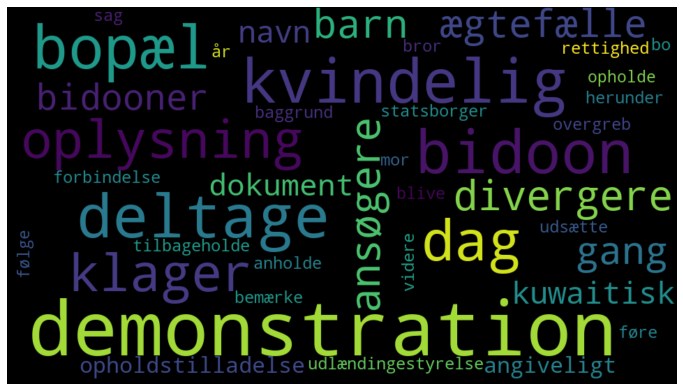

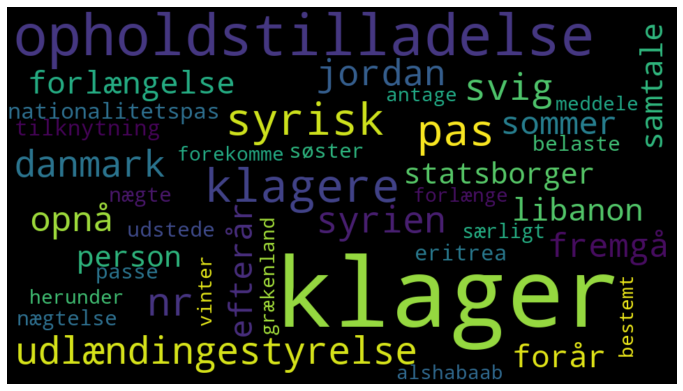

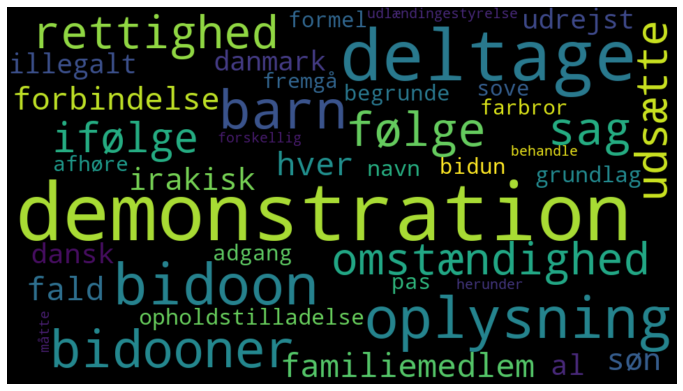

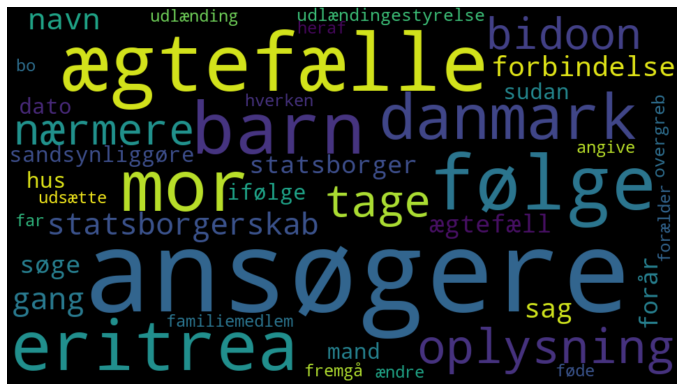

In [76]:
wordcloud_topics(SVD_model, count_text_vectorizer.get_feature_names_out())

**WordClouds from Kmeans clustering**:

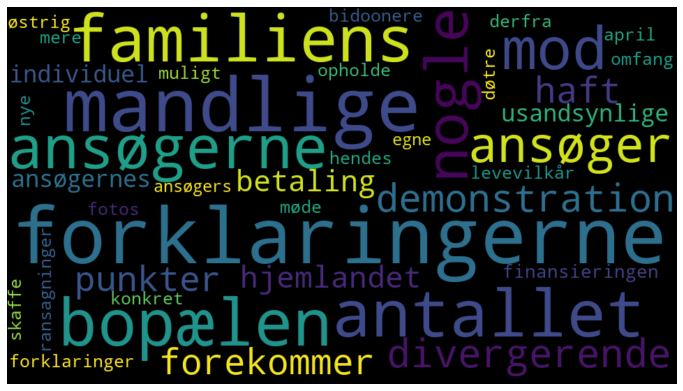

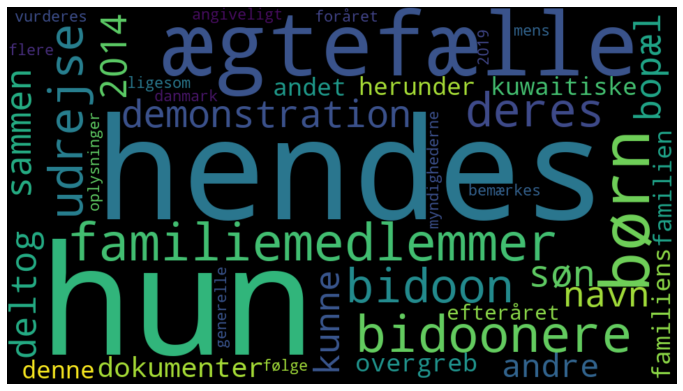

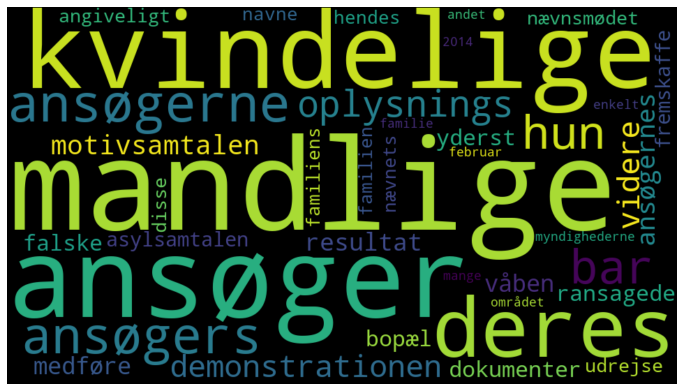

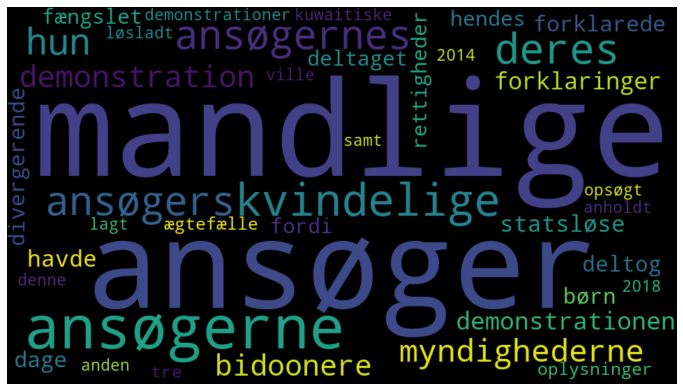

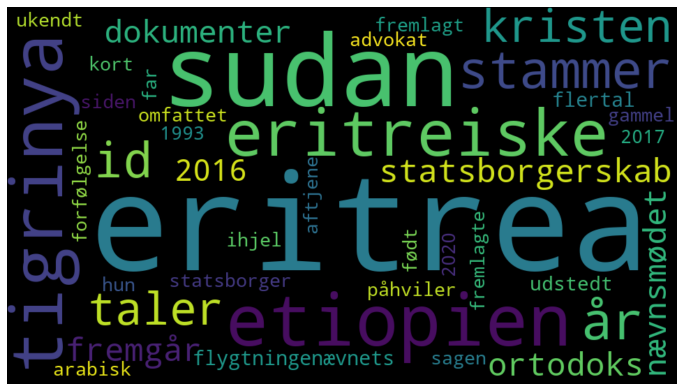

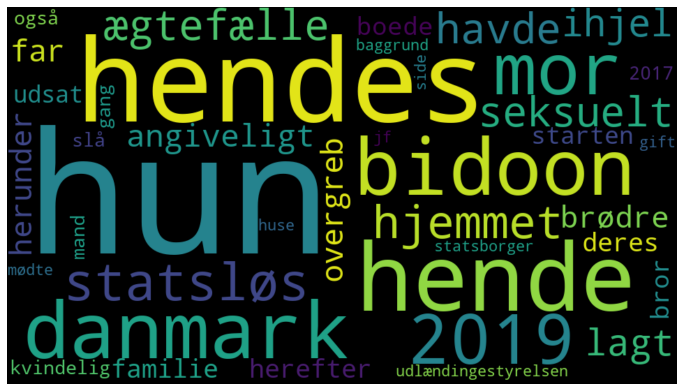

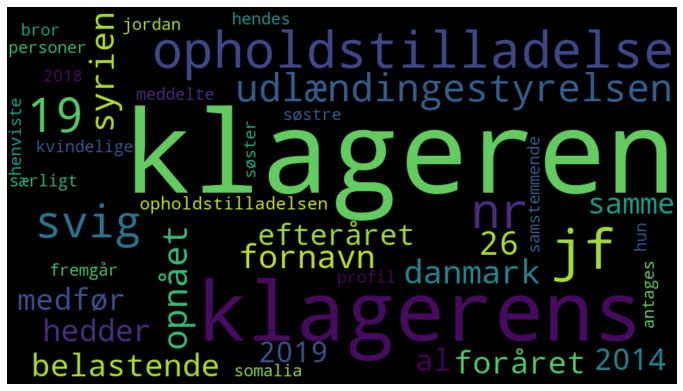

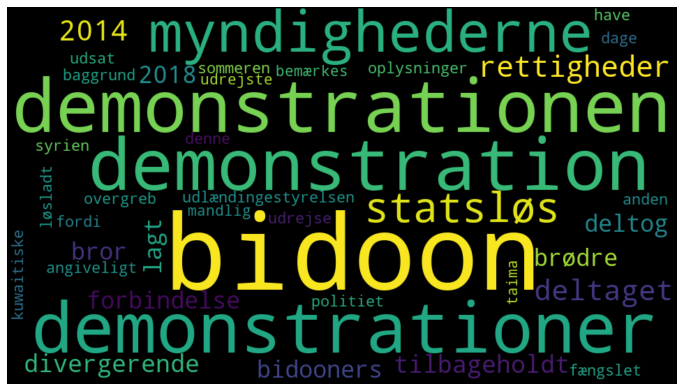

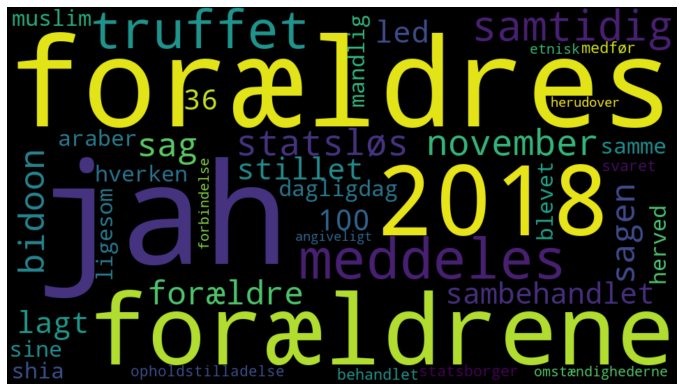

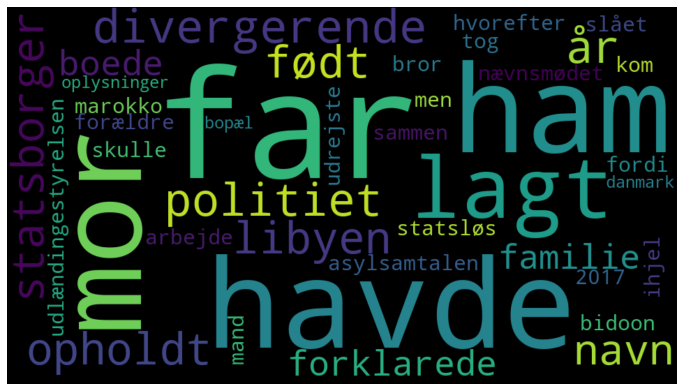

In [77]:
wordcloud_clusters(k_means_text, tfidf_text_vectors, tfidf_text_vectorizer.get_feature_names_out())